# Install the required libraries

In [1]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.0/569.0 kB 8.5 MB/s eta 0:00:00


In [3]:
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00


In [4]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import time
from torch_geometric.datasets import Entities
from torch_geometric.nn import FastRGCNConv, RGCNConv
from torch_geometric.utils import k_hop_subgraph
import matplotlib.pyplot as plt

In [5]:
import pandas as pd
from rdflib import Graph, URIRef
from pykeen.triples import TriplesFactory
from collections import Counter

INFO:pykeen.utils:Using opt_einsum


In [6]:
from pykeen.pipeline import pipeline
from pykeen.models import DistMult
from pykeen.evaluation import RankBasedEvaluator

# Download the dataset

In [7]:
!mkdir ./data
!wget "https://www.dropbox.com/sh/ldjd70yvnu9akxi/AAAam7SBr5KXLfjk-NVGQNWRa?dl=1" -O "./data/aifb.zip"
!unzip "data/aifb.zip" -d "data/aifb"

--2025-10-30 14:57:19--  https://www.dropbox.com/sh/ldjd70yvnu9akxi/AAAam7SBr5KXLfjk-NVGQNWRa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6033:18::a27d:5312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/5bkj2o1g1z5f5bv2x4lxj/ALDrm561FEhqGEoMe-qK3YY?rlkey=e7wqtjfh6gmqc5tpql5kkkkxp&dl=1 [following]
--2025-10-30 14:57:20--  https://www.dropbox.com/scl/fo/5bkj2o1g1z5f5bv2x4lxj/ALDrm561FEhqGEoMe-qK3YY?rlkey=e7wqtjfh6gmqc5tpql5kkkkxp&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15b7448c090c4f3396599389cd.dl.dropboxusercontent.com/zip_download_get/CXnzQsx9BuLBPFXex3a8a5WIuiYJDVVQXD_g2l0-LioudFv7cE7kfw-7vvUdUyVxheVs61jn1P8I6Mo-9NvGPVLrWr3EhyBe2_AnbsYy0LP0OQ# [following]
--2025-10-30 14:57:21--  https://uc15b7448c090c4f3396599389cd.dl.dropboxusercontent.com/zip

# Another approach for training:The dataset has no X which is the input features, in this method, I am using an emdedding technique to generate embedding for each node to be used as the features vectors, and test its effect of the model performance

In [8]:
def st(node):
    """
    Maps an rdflib node to a unique string. We use str(node) for URIs (so they can be matched to the classes) and
    we use .n3() for everything else, so that different nodes don't become unified.

    Source: https://github.com/pbloem/gated-rgcn/blob/1bde7f28af8028f468349b2d760c17d5c908b58b/kgmodels/data.py#L16
    """
    if type(node) == URIRef:
        return str(node)
    else:
        return node.n3()

g = Graph()
g.parse('/content/data/aifb/aifb_stripped.nt', format='nt')
data=[]
nodes = set()
relations = Counter()
for s, p, o in g:
        nodes.add(st(s))
        nodes.add(st(o))

        relations[st(p)] += 1

i2n = list(nodes) # maps indices to labels
n2i = {n:i for i, n in enumerate(i2n)} # maps labels to indices

for s, p, o in g:
    data.append([st(s), st(p), st(o)])
AIFB_df=pd.DataFrame(data, columns=['subject', 'predicate', 'object'])



# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(triples=AIFB_df.values, create_inverse_triples=True)
training = triples_factory
validation = triples_factory
testing = triples_factory

d=training
id_to_entity={v: k for k, v in d.entity_to_id.items()}
id_to_relation={v: k for k, v in d.relation_to_id.items()}

# Display the first few triples
triples_factory.triples

array([['_:N01b3732211424a17ad019cec219710bc',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#Restriction'],
       ['_:N01b3732211424a17ad019cec219710bc',
        'http://www.w3.org/2002/07/owl#allValuesFrom',
        'http://www.w3.org/2001/XMLSchema#string'],
       ['_:N01b3732211424a17ad019cec219710bc',
        'http://www.w3.org/2002/07/owl#onProperty',
        'http://swrc.ontoware.org/ontology#number'],
       ...,
       ['http://www.aifb.uni-karlsruhe.de/WBS/dvr/owltools/merge/type',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#DatatypeProperty'],
       ['http://www.w3.org/2001/XMLSchema#string',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#Datatype'],
       ['http://www.w3.org/2002/07/owl#Thing',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#Class']], dtype='<U3807')

In [9]:
result = pipeline(
    model='RotatE',
    loss="MarginRankingLoss",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=64),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.001),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=100, use_tqdm_batch=False),  # Increase the number of epochs
)
# The trained model is stored in the pipeline result
model = result.model

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.triples.triples_factory:Creating inverse triples.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cpu:   0%|          | 0.00/29.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1125.34s seconds


In [10]:
# Create an evaluator
evaluator = RankBasedEvaluator()
# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])
# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cpu:   0%|          | 0.00/29.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 997.60s seconds


Hits@1: 0.7944771545639224
Hits@3: 0.8864958854112868
Hits@5: 0.9153668698137245
Hits@10: 0.9450986468340048
Mean Reciprocal Rank: 0.8488573431968689


In [11]:
entity_emb=model.entity_representations[0]._embeddings
rel_emb=model.relation_representations[0]._embeddings

In [12]:
entity_emb.weight[0]

tensor([ 0.4127,  0.2843,  0.0394, -0.3236,  0.4477,  0.4791,  0.2321, -0.3085,
         0.0415,  0.2291, -0.4976,  0.1237,  0.2310, -0.1817, -0.3359, -0.3442,
        -0.3493, -0.3165, -0.0930, -0.2493, -0.6366,  0.2582,  0.2950,  0.4011,
        -0.5577, -0.0586,  0.6271, -0.2689, -0.3264,  0.1522,  0.2119, -0.0439,
        -0.0673, -0.4435, -0.2434, -0.0492,  0.2444,  0.2907,  0.4449,  0.2007,
        -0.3689, -0.4946,  0.1962,  0.5006,  0.4215, -0.1065, -0.5944, -0.2350,
         0.3588, -0.3184, -0.3923,  0.2824,  0.1381, -0.4458, -0.2463, -0.0784,
        -0.5191,  0.0547, -0.1454,  0.1847,  0.0326, -0.3838, -0.0642,  0.1841,
         0.2226, -0.2626, -0.3820,  0.4823,  0.0932,  0.2810, -0.3878, -0.2675,
         0.3859, -0.5907,  0.3601,  0.5022,  0.1011,  0.1370,  0.0254, -0.1402,
        -0.3092,  0.4114,  0.0059,  0.2095, -0.2492, -0.6096, -0.3982, -0.2989,
         0.1545,  0.4337,  0.1704, -0.3298,  0.1922,  0.1225, -0.1834, -0.0695,
         0.2803, -0.2904, -0.3651,  0.48

In [13]:
entity_emb

Embedding(8285, 128)

In [14]:
rel_emb

Embedding(90, 128)

In [15]:
AIFB_RotatE_entity_emb_128_dict={ training.entity_id_to_label[i]:entity_emb.weight[i].detach().tolist() for i in range(entity_emb.weight.shape[0])}
import pickle
with open("AIFB_RotatE_entity_emb_128_dict.pkl", "wb") as file:
    pickle.dump(AIFB_RotatE_entity_emb_128_dict, file)

# Untill here, the nodes embedding have been created.
# Now, train R-gcn model on the nodes using the embeddings

In [16]:
# Download the data, the processed version for thr entity predection task
dataset="AIFB"
#Conv = FastRGCNConv
Conv = RGCNConv
dataset = Entities('data/Entities',dataset)
data = dataset[0]

Extracting data/Entities/aifb.tgz
Processing...
Done!


In [17]:
data

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [18]:
# This section is useful for large graphs; BGS and AM graphs are too big to process them in a full-batch fashion.
# Since our model does only make use of a rather small receptive field, we
# filter the graph to only contain the nodes that are at most 2-hop neighbors
# away from any training/test node.
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 2, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]

In [19]:
#read the embeddings
import pickle
with open("AIFB_RotatE_entity_emb_128_dict.pkl", "rb") as file:
    AIFB_RotatE_entity_emb_128_dict=pickle.load(file)

In [20]:
#the flag here to check whether to use embeddings
use_feat=True
if use_feat:
  data.x = torch.Tensor(data.num_nodes, len(AIFB_RotatE_entity_emb_128_dict[list(AIFB_RotatE_entity_emb_128_dict.keys())[0]]))
  torch.nn.init.xavier_uniform_(data.x)

  i2n={v: k for k, v in n2i.items()}
  count=0
  for i in range(data.num_nodes):
    # print(i)
    if i2n[i] in AIFB_RotatE_entity_emb_128_dict:
      count+=1
      data.x[i]=torch.Tensor(AIFB_RotatE_entity_emb_128_dict[i2n[i]])
else:
  data.x=None

In [21]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv( data.x.shape[1] if data.x is not None else data.num_nodes, 32, dataset.num_relations,num_bases=30)
        self.conv2 = Conv(32, dataset.num_classes, dataset.num_relations,num_bases=30)

    def forward(self,edge_index, edge_type,x=None):

        y= F.relu(self.conv1(x, edge_index, edge_type))
        y = self.conv2(y, edge_index, edge_type)
        return F.log_softmax(y, dim=1)


In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)

In [23]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type,data.x)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type,data.x).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, test_acc


In [24]:
times = []
train_loss= []
accs_train= []
accs_test= []
for epoch in range(1, 20):
    start = time.time()
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} 'f'Test: {test_acc:.4f}')
    accs_test.append(test_acc)
    accs_train.append(train_acc)
    train_loss.append(loss)

    times.append(time.time() - start)

/tmp/ipython-input-3233952467.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)


Epoch: 01, Loss: 2.2947, Train: 0.4786 Test: 0.5000
Epoch: 02, Loss: 1.1132, Train: 0.8643 Test: 0.7778
Epoch: 03, Loss: 0.4703, Train: 0.9286 Test: 0.9167
Epoch: 04, Loss: 0.2222, Train: 0.9571 Test: 0.9444
Epoch: 05, Loss: 0.1519, Train: 0.9643 Test: 0.9167
Epoch: 06, Loss: 0.1134, Train: 0.9786 Test: 0.9167
Epoch: 07, Loss: 0.0837, Train: 0.9786 Test: 0.9167
Epoch: 08, Loss: 0.0612, Train: 0.9786 Test: 0.9167
Epoch: 09, Loss: 0.0443, Train: 0.9929 Test: 0.9167
Epoch: 10, Loss: 0.0330, Train: 0.9929 Test: 0.9167
Epoch: 11, Loss: 0.0262, Train: 1.0000 Test: 0.9444
Epoch: 12, Loss: 0.0227, Train: 1.0000 Test: 0.9444
Epoch: 13, Loss: 0.0203, Train: 1.0000 Test: 0.9444
Epoch: 14, Loss: 0.0178, Train: 1.0000 Test: 0.9444
Epoch: 15, Loss: 0.0149, Train: 1.0000 Test: 0.9444
Epoch: 16, Loss: 0.0121, Train: 1.0000 Test: 0.9444
Epoch: 17, Loss: 0.0095, Train: 1.0000 Test: 0.9444
Epoch: 18, Loss: 0.0074, Train: 1.0000 Test: 0.9444
Epoch: 19, Loss: 0.0058, Train: 1.0000 Test: 0.9444


In [25]:
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Median time per epoch: 0.8990s


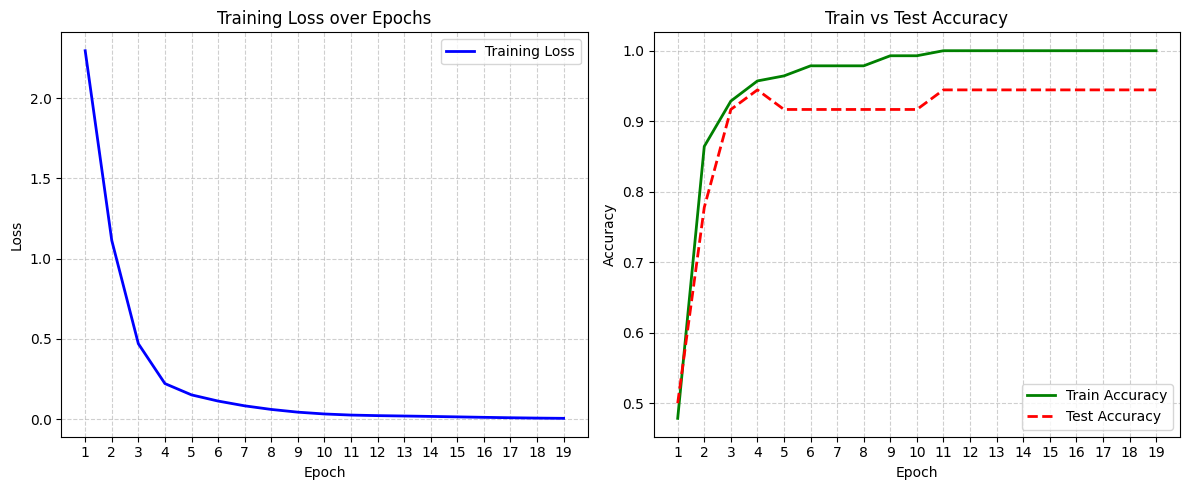

In [26]:
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Plot Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- Plot Train vs Test Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accs_train, 'g-', linewidth=2, label='Train Accuracy')
plt.plot(epochs, accs_test, 'r--', linewidth=2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')

plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('Embedding-based-R-GCN training and testing results.png', dpi=300, bbox_inches='tight')
plt.show()
